In [1]:
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit,  fsolve, minimize
from io import BytesIO
import sympy as smp
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from skimage.measure import EllipseModel
from astroquery.gaia import Gaia
from scipy.signal import convolve2d
from skimage.measure import label as ConnectRegion
from scipy.ndimage import gaussian_filter

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import ztfidr
import galaxy_phot as glp

sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

gaia_map_10 = pd.read_csv('csv_files/gaia_brick10_map.csv', index_col=0)

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index

In [2]:
importlib.reload(glp)
tbm = ['ZTF20acwmpsj', 'ZTF19acmvrsw', 'ZTF19acrddcz', 'ZTF19ackjmge',
        'ZTF18aahfzea', 'ZTF20aaummmc', 'ZTF19acymzwh']

In [363]:
sn_name = tbm[2]
sn_name = 'ZTF18acatuts' 
gd = glp.galaxy_decomp(sn_name, verbose=True, mask=False, band='g', size=200, source='query', catalog='ztf')
gd.gobj.brick

ZTF18acatuts 336.49589303059406 3.4600505268453903 0.03683002 z_snid
dr10 200 200


{'brickname': '3365p035',
 'psfsize': 1.7104517,
 'psfdepth': 24.778942,
 'galdepth': 24.564114,
 'sky': -1.3217754e-05,
 'sky_mag': 63.114172814996316}

In [364]:
ra, dec = gd.gobj.gal['host']
coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')

size = u.Quantity(gd.image.shape[0] * 0.262/3600, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=size, height=size)
masks_gaia = r[['ra', 'dec']]
masks_gaia['radius'] = 10
masks_gaia['check'] = 0

INFO: Query finished. [astroquery.utils.tap.core]


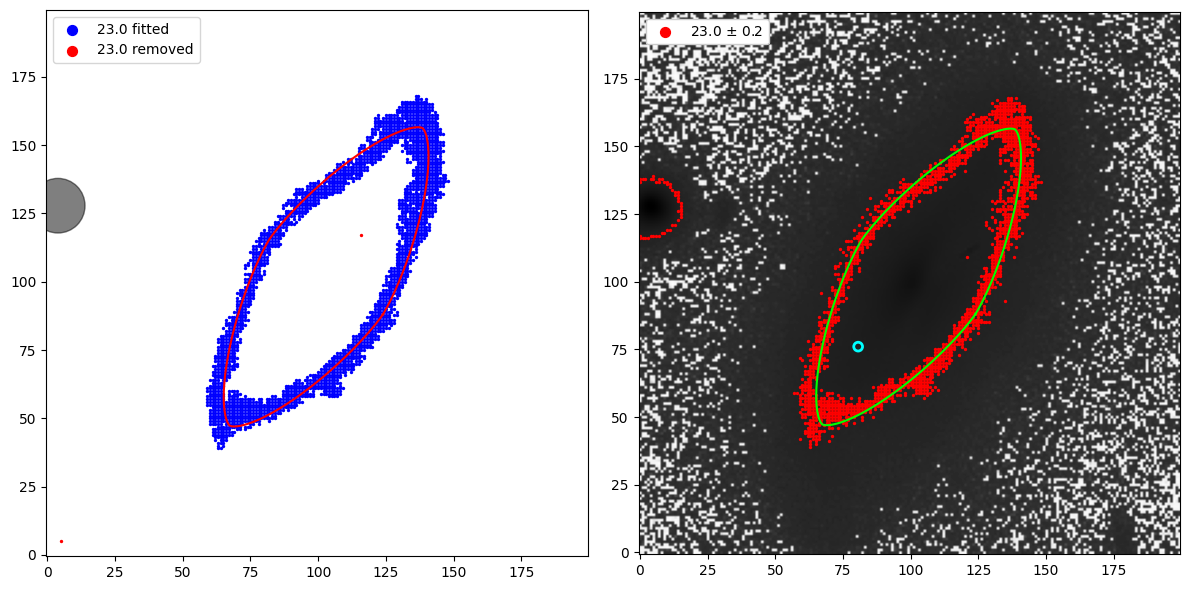

In [365]:
mask_data= masks_gaia.to_pandas().values
iso=23
gd.contour_fit(iso, window=0.3, mask=mask_data)
ax1, ax2 = gd.plot_fit([iso], width=0.2, mask=mask_data, zoom=False)

In [366]:
def prep_px(iso, wi):
    kernal3 = np.array([[ 0,  1,  1],
                        [ -1,  0,  1],
                        [-1,  -1,  0,]])

    kernal_ = 1/(kernal3 + iso)
    kernal_unit = kernal_ / np.sum(kernal_)
    convolve_1 = convolve2d(gd.image, kernal_unit, mode='same')
    convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

    convolve_2[:5,:] = 0
    convolve_2[-5:,:] = 0
    convolve_2[:,:5] = 0
    convolve_2[:,-5:] = 0

    contour = np.stack(np.where((convolve_2.T > iso-wi) & (convolve_2.T < iso+wi)))

    binary_image = np.zeros_like(gd.image, dtype=np.uint8)
    binary_image[contour[0], contour[1]] = 1
    connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
    region_count = np.asarray(np.unique(connect_, return_counts=True)).T[1:].T
    return region_count, connect_


def get_pixels(region, connect): 
    return np.stack(np.where(connect == region))

def super_ellipse_fitter(data):
    ell = EllipseModel()
    ell.estimate(data)
    if ell.params is None:
        return np.zeros(4), np.ones(4)*np.inf, (0,0)
    xc, yc, a, b, pa = ell.params
    x, y = data.T
    r = np.sqrt((x-xc)**2 + (y-yc)**2)
    phi = np.arctan2(y-yc, x-xc)
    out_pars = curve_fit(gd.super_ellipse, phi, r, p0=[a, b, pa, 2], maxfev=5000)
    return out_pars[0], np.sqrt(np.diag(out_pars[1])), (xc, yc)

In [416]:
def optimal(window, iso):
    count_r, connect = prep_px(iso, window)
    try:
        data = np.stack(np.where(connect == count_r[0][np.argmax(count_r[1])])).T
        pars, errs, center = super_ellipse_fitter(data)
    except (RuntimeError, ValueError):
        return 1
    else:
        return np.sum((errs/pars)**2)

In [430]:
mags = np.arange(18, 25, 0.2)
out = np.zeros_like(mags)
init_opt = 0.2
for i, iso in enumerate(mags):
    res = minimize(optimal, init_opt, args=(iso), bounds=[(0.1, 0.5)], method='Powell', tol=0.1)
    out[i] = res.x
    init_opt = res.x

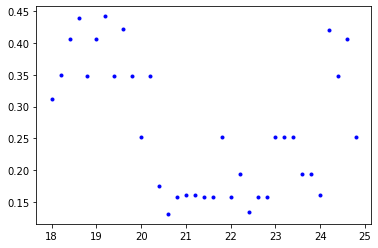

In [431]:
plt.plot(mags, out, 'b.')

In [419]:
errs/pars

array([0.08835857, 0.12185646, 0.08811084, 0.33381823])

In [420]:
iso=20
res = minimize(optimal, 0.2, args=(iso), bounds=[(0.1, 0.5)], method='Powell', tol=0.1)
res.x

array([0.25298051])

In [423]:
count_r, connect = prep_px(iso, res.x)
data = np.stack(np.where(connect == count_r[0][np.argmax(count_r[1])])).T
pars, errs, center = super_ellipse_fitter(data)

In [424]:
errs

array([0.35564427, 0.312963  , 0.1398783 , 0.90219428])

In [425]:
errs

array([0.35564427, 0.312963  , 0.1398783 , 0.90219428])

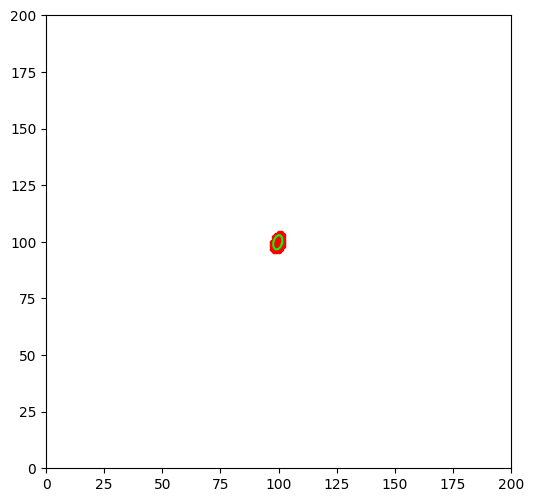

In [426]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.plot(data.T[0], data.T[1], 'r.')
ax.set_ylim([0, 200])
ax.set_xlim([0, 200])
gd.patch_super_ellipse(pars, center, ax, 'lime')

NameError: name 'region_count' is not defined

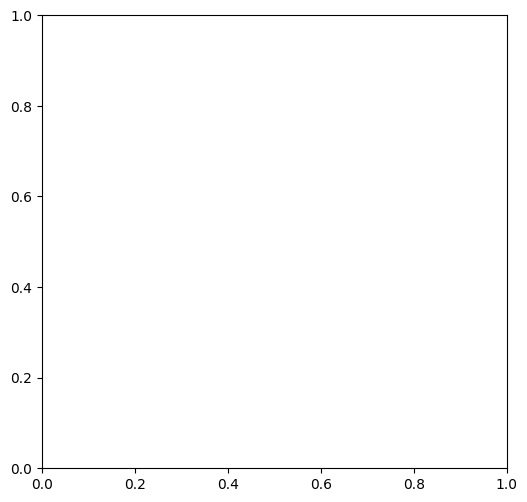

In [27]:
c = SkyCoord(ra=masks_gaia['ra'].value*u.degree, dec=masks_gaia['dec'].value*u.degree, frame='icrs')
gx, gy = gd.gobj.cutout['wcs'].world_to_pixel(c)
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(1, len(region_count.T)):
    xi, yi = get_pixels(i, connect_) 
    ax.plot(xi, yi, marker='o', linestyle='none', label=f'{i}')
ax.set_ylim([0, 300])
ax.set_xlim([0, 300])
ax.plot(gx, gy, 'k.')
ax.legend()

In [86]:
# ell = EllipseModel()
# ell.estimate(data)

In [7]:
# loc_ = gaia_map_10[gaia_map_10['brickname'] == gd.gobj.brick['brickname']]
# mask_df = hdu[1].data[loc_.iloc[0]['start']:loc_.iloc[0]['end']] 
# # the radius of a BRIGHT mask is half that for a MEDIUM mask, mask_df['radius_pix']*(mask_df['isbright']*-0.5+1)
# ra_m, dec_m = mask_df['ra'], mask_df['dec']

# ra_gal, dec_gal = gd.gobj.gal['host']
# dist = np.sqrt((ra_m-ra_gal)**2 + (dec_m-dec_gal)**2)
# mask_i = np.where(dist < gd.image.shape[0] * 0.262/3600)[0]

# mask_data = Table(mask_df)[['ra', 'dec', 'radius_pix', 'isbright']].to_pandas().iloc[mask_i].values.astype(float)
# file_name = 'fits_files/gaia-mask-dr10.fits.gz'
# hdu = fits.open(file_name, memmap=True)
# header = hdu[1].header
# hdu[1].data[0:1] # load hdu ~ 1mins
# start_index = []
# brick_names = []
# current_name = ''
# for i in range(round(header['NAXIS2']/1e6)):
#     print(i)
#     data_i = Table(hdu[1].data[int((i)*1e6): int((i+1)*1e6)])['brickname']
#     for j, name in enumerate(pd.Series(data_i)):
#         if name != current_name:
#             current_name = name
#             brick_names.append(name)
#             start_index.append(i*1e6+j)

# df = pd.DataFrame([brick_names, start_index]).T
# df.columns=['brickname', 'start']
# end_index = np.roll(df['start'].values, -1)
# end_index[-1] = header['NAXIS2']
# df['end'] =  end_index

# # df.to_csv('csv_files/gaia_brick10_map.csv')

# file_name = 'fits_files/SGA-ellipse-v3.0.kd.fits'
# hdu1 = fits.open(file_name, memmap=True)
# data1 = hdu1[1].data[:1000]